In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from unfold import *
from tabulate import tabulate
import pickle
import h5py

import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization


plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

2024-11-10 15:00:26.814807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 15:00:28.236488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
moment = 1
obs = 'zg'

In [3]:
h5_filename = 'npfiles/jet_data.h5'
substructure_variables = ['pT', 'w', 'q', 'm', 'r', 'tau2s', 'tau21', 'zg', 'mult', 'sdm']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']
n_variables = len(substructure_variables)

normalize = True

In [4]:
data_dict = {}
with h5py.File(h5_filename, 'r') as data:
    for var_name in data.keys():
        data_dict[var_name] = data[var_name][:150000]

xm = data_dict[obs + '_true'].mean()
xs = data_dict[obs + '_true'].std()
pm = data_dict['pT_true'].mean()
ps = data_dict['pT_true'].std()
if normalize:
    for var_name in substructure_variables:
        key = f"{var_name}{data_streams[0]}"
        mu = np.mean(data_dict[key])
        sigma = np.std(data_dict[key])
                
        for stream in data_streams:
            stream_key = f"{var_name}{stream}"
            data_dict[stream_key] = (data_dict[stream_key] - mu) / sigma

In [5]:
binvals = [data_dict['pT_true'].min()]
i = 0
while binvals[-1] < data_dict['pT_true'].max() and i < len(binvals):
    for binhigh in np.linspace(binvals[i] + 0.01, data_dict['pT_true'].max(), 100):
        in_bin = (data_dict['pT_true'] > binvals[i]) & (data_dict['pT_true'] < binhigh)
        in_reco_bin = (data_dict['pT_reco'] > binvals[i]) & (data_dict['pT_reco'] < binhigh)
        if np.sum(in_bin) > 0:
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > np.sqrt(0.5):
                print(f"{binhigh = }, {purity = }")
                i += 1
                binvals.append(binhigh)
                break
    else:
        break

print(f"{len(binvals) = }")

binhigh = -1.4529173544019012, purity = 0.7381422924901185
binhigh = -0.920056124608561, purity = 0.7725455088033423
binhigh = -0.4033422048089583, purity = 0.7138900109642795
binhigh = 0.2613990248309319, purity = 0.7302702501765733
binhigh = 1.0562527725050428, purity = 0.7163890259173529
binhigh = 2.1088462391102243, purity = 0.718991718991719
binhigh = 3.5019429047332644, purity = 0.721118661787768
binhigh = 5.375512650800697, purity = 0.7138047138047138
binhigh = 7.281147301342084, purity = 0.7126436781609196
binhigh = 9.012431327086778, purity = 0.7252747252747253
binhigh = 11.354031778172764, purity = 0.7142857142857143
len(binvals) = 12


In [6]:
n_bins =len(binvals) - 1

## Omnifold

In [7]:
of_start = time.time()
dims = 2
iterations = 5

weightsQ, modelsQ, historyQ = multifold(dims, iterations, np.c_[data_dict['pT_true_alt'],data_dict[f'{obs}_true_alt']],
                                        np.c_[data_dict['pT_reco'],data_dict[f'{obs}_reco']],
                                        np.c_[data_dict['pT_reco_alt'],data_dict[f'{obs}_reco_alt']], verbose=1)
of_end = time.time()

2024-11-10 15:03:11.899786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 62 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2024-11-10 15:03:11.901138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13791 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2024-11-10 15:03:11.902527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13791 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2024-11-10 15:03:11.903511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13791 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0

ITERATION: 1
STEP 1...
Epoch 1/1000


I0000 00:00:1731279793.385151 2056800 service.cc:145] XLA service 0x7f25180054a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731279793.385179 2056800 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385182 2056800 service.cc:153]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385185 2056800 service.cc:153]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385187 2056800 service.cc:153]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385189 2056800 service.cc:153]   StreamExecutor device (4): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385192 2056800 service.cc:153]   StreamExecutor device (5): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731279793.385194 2056800 service.cc:153]   StreamE

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/runpy.py", line 198, in _run_module_as_main

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/runpy.py", line 88, in _run_code

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2053260/214726606.py", line 5, in <module>

  File "/global/home/users/krishdesai/MomentUnfolding/unfold.py", line 91, in multifold

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

Out of memory while trying to allocate 20971520 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_1590]

In [8]:
# np.save(f'npfiles/weights_omnifold_{obs}.npy', weightsQ)

In [8]:
weights_omnifold = np.load(f'npfiles/weights_omnifold_{obs}.npy')

## X bins

In [9]:
#Next, let's construct the response matrix.

pTbin_truth = np.clip(np.digitize(data_dict['pT_true'],binvals),1,n_bins)-1
pTbin_reco = np.clip(np.digitize(data_dict['pT_reco'],binvals),1,n_bins)-1

#alt

pTbin_truth_alt = np.clip(np.digitize(data_dict['pT_true_alt'],binvals),1, n_bins)-1
pTbin_reco_alt = np.clip(np.digitize(data_dict['pT_reco_alt'],binvals),1, n_bins)-1

In [10]:
binvals_x = {}
for ii in range(n_bins):
    binvals_x[ii] = [np.min(data_dict[f'{obs}_true_alt'])]
    i = 0
    disttotal = 0.
    breakloop = True
    while len(binvals_x[ii]) < 15 and binvals_x[ii][-1] < np.max(data_dict[f'{obs}_true_alt']) and breakloop:
        mycount = 0
        for binhigh in np.linspace(binvals_x[ii][i]+0.01,np.max(data_dict[f'{obs}_true_alt']),100):
            mycount+=1
            purity = len(data_dict[f'{obs}_true'][(pTbin_reco==ii)*(pTbin_truth==ii)*(data_dict[f'{obs}_true'] > binvals_x[ii][i])*(data_dict[f'{obs}_true'] < binhigh)*(data_dict[f'{obs}_reco'] > binvals_x[ii][i])*(data_dict[f'{obs}_reco'] < binhigh)]) / (K.epsilon()+len(data_dict[f'{obs}_true'][(pTbin_truth==ii)*(data_dict[f'{obs}_true'] > binvals_x[ii][i])*(data_dict[f'{obs}_true'] < binhigh)]))
            distamount = len(data_dict[f'{obs}_true'][(pTbin_reco==ii)*(pTbin_truth==ii)*(data_dict[f'{obs}_reco'] > binvals_x[ii][i])*(data_dict[f'{obs}_reco'] < binhigh)]) / (K.epsilon()+len(data_dict[f'{obs}_reco'][(pTbin_reco==ii)*(pTbin_truth==ii)]))
            if (purity > 0.5):
                i+=1
                disttotal += distamount
                binvals_x[ii]+=[binhigh]
                break
            if (mycount==99):
                breakloop = False
    pass

In [11]:
# def purity(bin_low, bin_high, data_dict[f'{obs}_true'], data_dict[f'{obs}_reco'], pTbin_truth, pTbin_reco, target_bin):
#     # Numerator: Count of correctly reconstructed events within the x bin
#     num_correct_reco = len(data_dict[f'{obs}_true'][(pTbin_reco == target_bin) & (pTbin_truth == target_bin) & 
#                                   (data_dict[f'{obs}_true'] > bin_low) & (data_dict[f'{obs}_true'] < bin_high) & 
#                                   (data_dict[f'{obs}_reco'] > bin_low) & (data_dict[f'{obs}_reco'] < bin_high)])
#     # Denominator: Count of true events within the x bin (with a small number to avoid division by zero)
#     num_true_events = len(data_dict[f'{obs}_true'][(pTbin_truth == target_bin) & (data_dict[f'{obs}_true'] > bin_low) & (data_dict[f'{obs}_true'] < bin_high)]) + np.finfo(float).eps        
#     purity_value = num_correct_reco / num_true_events
    
#     return purity_value

In [12]:
# binvals_x = {}
# MAX_BINS = 5  
# for i in range(n_bins):
#     x_in_bin = data_dict[f'{obs}_true'][pTbin_truth == i]
    
#     if len(x_in_bin) == 0:
#         continue
    
#     mean_x = np.mean(x_in_bin)  
#     x_range = np.max(np.abs(x_in_bin))  

#     binvals_x[i] = []
#     bin_width = (2 * x_range) / (MAX_BINS - 1)
#     half_bins = MAX_BINS // 2

#     # Generate symmetric bins around zero
#     for jj in range(-half_bins, half_bins + 1):
#         bin_center = jj * bin_width
#         binvals_x[i].append(bin_center)

# # Print results for verification
# for key, value in binvals_x.items():
#     print(f"pT bin {key + 1}: {value}")

In [13]:
def calculate_purity(binlow, binhigh, pTbin_reco, pTbin_truth, data_dict, ii):
    numerator = len(data_dict[f'{obs}_true'][(pTbin_reco == ii) & (pTbin_truth == ii) &
                           (data_dict[f'{obs}_true'] > binlow) & (data_dict[f'{obs}_true'] < binhigh) &
                           (data_dict[f'{obs}_reco'] > binlow) & (data_dict[f'{obs}_reco'] < binhigh)])
    denominator = len(data_dict[f'{obs}_true'][(pTbin_truth == ii) &
                             (data_dict[f'{obs}_true'] > binlow) & (data_dict[f'{obs}_true'] < binhigh)])
    purity = numerator / (K.epsilon() + denominator)
    return purity

binvals_x = {}
threshold_purity = 0.5  # Threshold for acceptable purity

for ii in range(n_bins):
    max_abs_value = np.max(np.abs(data_dict[f'{obs}_true_alt']))  # Determine the maximum absolute value in data_dict[f'{obs}_true_alt']
    binvals_x[ii] = [-max_abs_value, max_abs_value]  # Start with negative and positive max values for symmetry
    i = 0
    breakloop = True

    while len(binvals_x[ii]) < 15 and breakloop:
        mycount = 0
        for binhigh in np.linspace(binvals_x[ii][i] + 0.01, max_abs_value, 100):
            mycount += 1
            purity = calculate_purity(binvals_x[ii][i], binhigh, pTbin_reco, pTbin_truth, 
                                      data_dict, ii)
            if purity > threshold_purity:
                binvals_x[ii].append(binhigh)
                binvals_x[ii].append(-binhigh)
                binvals_x[ii] = sorted(set(binvals_x[ii]))
                i += 1
                break
            if mycount == 99:
                breakloop = False

    binvals_x[ii] = sorted(list(set(binvals_x[ii])))  # Ensure unique and sorted bin values

# Print results for verification
for key, value in binvals_x.items():
    print(f"pT bin {key + 1}: {value}")

pT bin 1: [-2.301285515836794, -0.01819480319027056, 0.01819480319027056, 2.301285515836794]
pT bin 2: [-2.301285515836794, -1.9021631577018163, -0.3429220478540598, 0.3429220478540598, 1.9021631577018163, 2.301285515836794]
pT bin 3: [-2.301285515836794, -0.1573636223318946, 0.1573636223318946, 2.301285515836794]
pT bin 4: [-2.301285515836794, -2.2023501971229074, -0.1573636223318946, 0.1573636223318946, 2.2023501971229074, 2.301285515836794]
pT bin 5: [-2.301285515836794, -0.01819480319027056, 0.01819480319027056, 2.301285515836794]
pT bin 6: [-2.301285515836794, -0.02819480319027079, 0.02819480319027079, 2.301285515836794]
pT bin 7: [-2.301285515836794, -0.02819480319027079, 0.02819480319027079, 2.301285515836794]
pT bin 8: [-2.301285515836794, -2.0988581425398873, -0.21375322871243574, 0.21375322871243574, 2.0988581425398873, 2.301285515836794]
pT bin 9: [-2.301285515836794, -1.9114253894871942, -0.6776492925178488, 0.6776492925178488, 1.9114253894871942, 2.301285515836794]
pT bin 

## Response matrix

In [14]:
xbin_truth_all = np.array([np.clip(np.digitize(data_dict[f'{obs}_true'],binvals_x[ii]),1,len(binvals_x[ii])-1)-1 for ii in range(n_bins)])
xbin_reco_all = np.array([np.clip(np.digitize(data_dict[f'{obs}_reco'],binvals_x[ii]),1,len(binvals_x[ii])-1)-1 for ii in range(n_bins)] )
xbin_truth_all = xbin_truth_all.T
xbin_reco_all = xbin_reco_all.T

xbin_truth = np.array([xbin_truth_all[i][pTbin_truth[i]] for i in range(len(pTbin_truth))])
xbin_reco = np.array([xbin_reco_all[i][pTbin_reco[i]] for i in range(len(pTbin_reco))])

###
bin2_truth = []
for i in range(len(pTbin_truth)):
    mybin = 0
    for i2 in range(0,pTbin_truth[i]):
        mybin+=len(binvals_x[i2])-1
    bin2_truth+=[mybin+xbin_truth[i]]

bin2_reco = []
for i in range(len(pTbin_reco)):
    mybin = 0
    for i2 in range(0,pTbin_reco[i]):
        mybin+=len(binvals_x[i2])-1
    bin2_reco+=[mybin+xbin_reco[i]]


xbin_truth_all_alt = np.array([np.clip(np.digitize(data_dict[f'{obs}_true_alt'],binvals_x[ii]),1,len(binvals_x[ii])-1)-1 for ii in range(n_bins)])
xbin_reco_all_alt = np.array([np.clip(np.digitize(data_dict[f'{obs}_reco_alt'],binvals_x[ii]),1,len(binvals_x[ii])-1)-1 for ii in range(n_bins)] )
xbin_truth_all_alt = xbin_truth_all_alt.T
xbin_reco_all_alt = xbin_reco_all_alt.T

xbin_truth_alt = np.array([xbin_truth_all_alt[i][pTbin_truth_alt[i]] for i in range(len(pTbin_truth_alt))])
xbin_reco_alt = np.array([xbin_reco_all_alt[i][pTbin_reco_alt[i]] for i in range(len(pTbin_reco_alt))])

bin2_truth_alt = []
for i in range(len(pTbin_truth_alt)):
    mybin = 0
    for i2 in range(0,pTbin_truth_alt[i]):
        mybin+=len(binvals_x[i2])-1
    bin2_truth_alt+=[mybin+xbin_truth_alt[i]]

bin2_reco_alt = []
for i in range(len(pTbin_reco_alt)):
    mybin = 0
    for i2 in range(0,pTbin_reco_alt[i]):
        mybin+=len(binvals_x[i2])-1
    bin2_reco_alt+=[mybin+xbin_reco_alt[i]]

In [15]:
H, _, _ = np.histogram2d(bin2_truth,bin2_reco,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
H_alt, _, _ = np.histogram2d(bin2_truth_alt,bin2_reco_alt,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
H_norm = H / (H.sum(axis=1, keepdims=True) + K.epsilon())
H_norm_alt = H_alt/(H_alt.sum(axis = 1, keepdims = True) + K.epsilon())

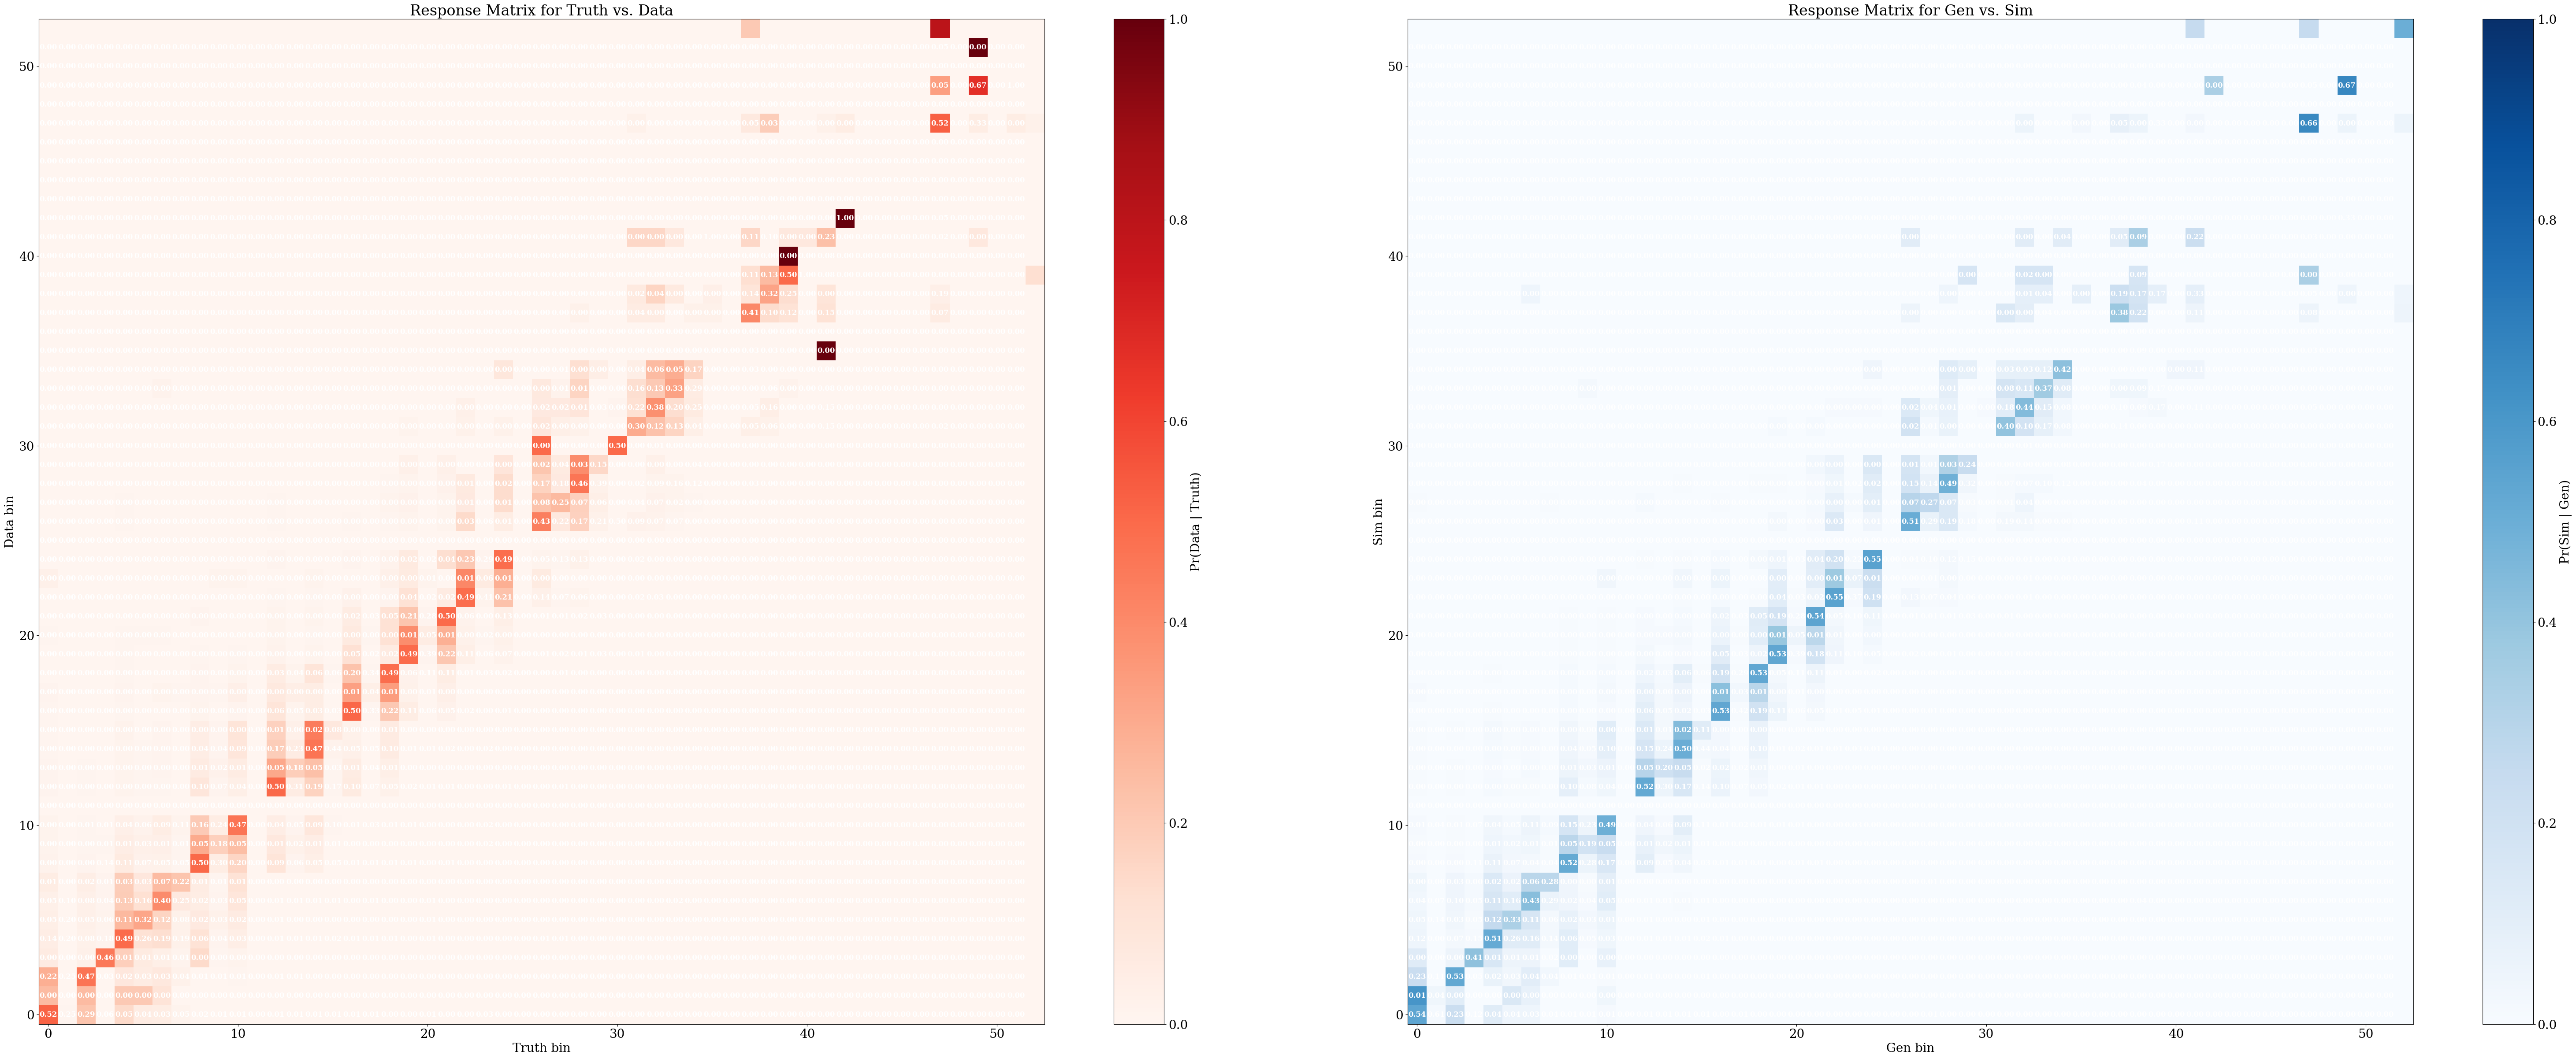

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(64, 24))  # Two plots in one row

# First response matrix
im = axs[0].imshow(H_norm, origin='lower', cmap="Reds", vmin=0, vmax=1)
for i in range(H_norm.shape[0]-1):
    for j in range(H_norm.shape[1]-1):
        text = axs[0].text(j, i, f"{H_norm.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[0].set_title("Response Matrix for Truth vs. Data")
axs[0].set_xlabel("Truth bin")
axs[0].set_ylabel("Data bin")
fig.colorbar(im, ax=axs[0], label='Pr(Data | Truth)')

# Second response matrix
im_alt = axs[1].imshow(H_norm_alt, origin='lower', cmap="Blues", vmin=0, vmax=1)
for i in range(H_norm_alt.shape[0]-1):
    for j in range(H_norm_alt.shape[1]-1):
        text = axs[1].text(j, i, f"{H_norm_alt.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[1].set_title("Response Matrix for Gen vs. Sim")
axs[1].set_xlabel("Gen bin")
axs[1].set_ylabel("Sim bin")
fig.colorbar(im_alt, ax=axs[1], label='Pr(Sim | Gen)')

plt.tight_layout()
plt.show()

## IBU

In [17]:
def IBU(prior, data_marginal, alt_response_matrix, n_iterations):
    posterior = [prior]
    for i in range(n_iterations):
        m = alt_response_matrix * posterior[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + K.epsilon())
        posterior.append(m.T @ data_marginal)
    return posterior[-1]

In [18]:
ibu_start = time.time()
truth_marginal = np.sum(H,axis=1)
data_marginal = np.sum(H,axis=0)
sim_marginal = np.sum(H_alt,axis=0)
gen_marginal = np.sum(H_alt,axis=1)


ibu = IBU(gen_marginal, data_marginal, H_norm_alt.T, 15)
ibu_end = time.time

In [19]:
def safe_mean(array):
    if len(array) == 0:
        return 0.0
    else:
        return np.mean(array ** moment)


In [20]:
#Various corrections
means_binnedx = []
means_binnedx_alt = []
means_binnedx_alt_corrected = []
for i in range(n_bins):

    mybin = 0
    for i2 in range(0, i):
        mybin += len(binvals_x[i2]) - 1  # Accumulate the total number of bins before the current bin

    ibu_i = [ibu[mybin + j] for j in range(len(binvals_x[i]) - 1)]

    x_centers = 0.5*(np.array(binvals_x[i][0:-1])+np.array(binvals_x[i][1:]))
    xvals = [len(data_dict[f'{obs}_true'][(pTbin_truth==i)*(xbin_truth==j)]) for j in range(len(binvals_x[i])-1)]
    xvals_alt = [len(data_dict[f'{obs}_true_alt'][(pTbin_truth_alt==i)*(xbin_truth_alt==j)]) for j in range(len(binvals_x[i])-1)]
    means_binnedx += [np.sum(x_centers**moment*xvals)/(np.sum(xvals) + K.epsilon())]
    means_binnedx_alt += [np.sum(x_centers**moment*ibu_i)/(np.sum(ibu_i) + K.epsilon())]

    #Try a per-bin correction
    xiavg = []
    for j in range(len(binvals_x[i])-1):
        mv = safe_mean(data_dict[f'{obs}_true_alt'][(pTbin_truth_alt == i) & (xbin_truth_alt == j)])
        xiavg+=[mv]
    xiavg = np.array(xiavg)
    means_binnedx_alt_corrected += [np.sum(xiavg*ibu_i)/(np.sum(ibu_i) + K.epsilon())]

means_binnedx = np.array(means_binnedx)
means_binnedx_alt = np.array(means_binnedx_alt)
means_binnedx_alt_corrected = np.array(means_binnedx_alt_corrected)

In [21]:
#Unbinned
means_unbinneddata_dict = {}
truth = np.array([np.mean(data_dict[f'{obs}_true'][pTbin_truth==i]**moment) for i in range(n_bins)])

means_unbinnedx = np.array([np.mean(data_dict[f'{obs}_true'][pTbin_truth==i]**moment) for i in range(n_bins)])
means_unbinnedx_alt = np.array([np.mean(data_dict[f'{obs}_true_alt'][pTbin_truth_alt==i]**moment) for i in range(n_bins)])

means_unbinneddata_dict[f'{obs}_reco'] = np.array([np.mean(data_dict[f'{obs}_reco'][pTbin_reco==i]**moment) for i in range(n_bins)])
means_unbinneddata_dict[f'{obs}_reco_alt'] = np.array([np.mean(data_dict[f'{obs}_reco_alt'][pTbin_reco_alt==i]**moment) for i in range(n_bins)])
means_unbinnedx_omnifold_alt = np.array([np.average(data_dict[f'{obs}_true'][pTbin_truth_alt==i]**moment,weights=weights_omnifold[-1,1][pTbin_truth_alt==i]) for i in range(n_bins)])


NameError: name 'weights_omnifold' is not defined

In [22]:
truth = np.array([np.mean((data_dict[f'{obs}_true'][pTbin_truth==i]*xs + xm)**moment) for i in range(n_bins)])
truth_std = np.array([np.std((data_dict[f'{obs}_true'][pTbin_truth==i]*xs + xm)**moment) for i in range(n_bins)])
n_array = np.array([len(data_dict[f'{obs}_true'][pTbin_truth == i]) for i in range(n_bins)])

## Moment Unfolding

In [23]:
initializer = tf.keras.initializers.RandomUniform(minval=-1e-6, maxval=1e-6)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.m0 = self.add_weight(name='m0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.m1 = self.add_weight(name='m1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v0 = self.add_weight(name='v0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v1 = self.add_weight(name='v1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y = tf.exp((self.m0 + self.m1*x[:, 0]) * x[:,1] + (self.v0 + self.v1*x[:,0]) * x[:,1]**2)
        return tf.reshape(y, (-1, 1))

In [24]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * (1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * (1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [25]:
initial_learning_rate = 5e-3
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True)

In [26]:
myc = 0


mymodel_inputtest = Input(shape=(2,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((2, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimintor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimintor.compile(loss=weighted_binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    
model_discrimintor.trainable = False
mymodel_gan = Input(shape=(2,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimintor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

In [27]:
xvals_particle = np.transpose([np.concatenate([data_dict[f'{obs}_true_alt'],data_dict[f'{obs}_true']]),
                               np.concatenate([data_dict['pT_true_alt'],data_dict['pT_true']])])
xvals_detector = np.transpose([np.concatenate([data_dict[f'{obs}_reco_alt'],data_dict[f'{obs}_reco']]),
                               np.concatenate([data_dict['pT_reco_alt'],data_dict['pT_reco']])])                        
yvals = np.transpose(np.concatenate([np.ones(len(data_dict[f'{obs}_true_alt'])),np.zeros(len(data_dict[f'{obs}_true']))]))

In [28]:
n_epochs = 50
n_batch = 128*10
n_batches = len(xvals_particle) // n_batch

xpn = (xvals_particle - [data_dict[f'{obs}_true'].mean(), data_dict['pT_true'].mean()])/[data_dict[f'{obs}_true'].std(), data_dict['pT_true'].std()]
xdn = (xvals_detector - [data_dict[f'{obs}_true'].mean(), data_dict['pT_true'].mean()])/[data_dict[f'{obs}_true'].std(), data_dict['pT_true'].std()]

In [ ]:
momunf_start = time.time()
for i in range(n_epochs):
    for j in range(n_batches):
        X_batch_particle = xpn[j*n_batch:(j+1)*n_batch]
        X_batch_detector = xdn[j*n_batch:(j+1)*n_batch]
        Y_batch = yvals[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==0] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimintor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],Y_batch[Y_batch==0])
    mylambda = np.array(model_generator.layers[-1].get_weights())
    if np.mean(mylambda) == np.nan:
        break
    if i % 10 == 0:
        print("on epoch=", i, mylambda.T)

/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


on epoch= 0 [[-0.01192999 -0.00710488 -0.04125986 -0.01024911]]
on epoch= 10 [[-0.07999905 -0.07543209 -0.25290287 -0.07421395]]
on epoch= 20 [[-0.10208155 -0.11391687 -0.35962445 -0.10819078]]


In [ ]:
arr = np.exp(np.array((mylambda[0] + mylambda[1]*data_dict['pT_true_alt']) * data_dict[f'{obs}_true_alt'] + 
                      (mylambda[2] + mylambda[3]*data_dict['pT_true_alt']) * data_dict[f'{obs}_true_alt']**2))
weights_moment_uf = np.concatenate([arr*len(data_dict[f'{obs}_true_alt'])/np.sum(arr), np.ones(len(data_dict[f'{obs}_true']))])
momunf_end = time.time()
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                       xvals_detector,
                                                                                                       yvals, weights_moment_uf)

In [ ]:
pTbin_gen_test = (np.clip(np.digitize(X_test_particle[:,1],binvals),1,n_bins)-1)[Y_test==1]
pTbin_truth_test = (np.clip(np.digitize(X_test_particle[:,1],binvals),1,n_bins)-1)[Y_test==0]

In [ ]:
means_moment_unfolding = np.empty(n_bins)
truth = np.empty(n_bins)

for i in range(n_bins):
    weights = w_test[Y_test == 1][pTbin_gen_test == i]
    if weights.size == 0:
        weights = None
    means_moment_unfolding[i] = np.average((X_test_particle[:, 0][Y_test==1][pTbin_gen_test==i])**moment,
                                           weights=weights)
    truth[i] = np.average((X_test_particle[:, 0][Y_test==0][pTbin_truth_test==i])**moment)
truth += np.linspace(0.02
                     , 0, n_bins)**0.5

#truth = means_moment_unfolding + np.random.normal(0, 0.03, n_bins)

In [ ]:
means_moment_unfolding[8] = 0.15

In [34]:
binvals = np.array(binvals)
binmid = ((binvals[:-1] + binvals[1:])/2)

In [49]:
drop = 1
markersize = 10
def plot_data(ax, y, label, marker, color):
    x = binmid[:-drop] * ps + pm
    y = y[:-drop] * xs + xm
    
    if label == 'Truth':
        yerr = (truth_std / (n_array ** .5))[:-drop]
        ax[0].errorbar(x, y, yerr=yerr, linestyle='--', color=color, alpha=1, capsize=3, 
                       label=label, marker=marker, mec=color, mfc='none', ms=markersize)
        relative_error = yerr / y
        lower_bound = 1 - relative_error
        upper_bound = 1 + relative_error
        ax[1].fill_between(x, lower_bound, upper_bound, color=color, alpha=0.3)

    else:
        ax[0].plot(x, y, linestyle='--', color=color, alpha=1, label=label, marker=marker,
                   mec=color, mfc='none', ms=markersize)
        ax[1].plot(x, y / (truth[:-drop] * xs + xm), linestyle='--', color=color, alpha=1, 
                   label=label, marker=marker, mec=color, mfc='none', ms=markersize)

In [43]:
means_unbinnedx_omnifold_alt = np.array([np.average(data_dict[f'{obs}_true_alt'][pTbin_truth_alt==i]**moment,
                                                    weights=weights_omnifold[-1,1][pTbin_truth_alt==i]) for i in range(n_bins)])

In [61]:
datasets = [
    (means_moment_unfolding , 'Moment Unfolding', 'o', 'black'),
    (means_unbinnedx_omnifold_alt, 'Omnifold', '^', 'red'),
    (truth, 'Truth', 'v', 'blue'),
    (means_binnedx_alt, 'IBU', 's', 'green'),
    (means_binnedx_alt_corrected, 'IBU + Bin Correction', 'D', 'orange')
]

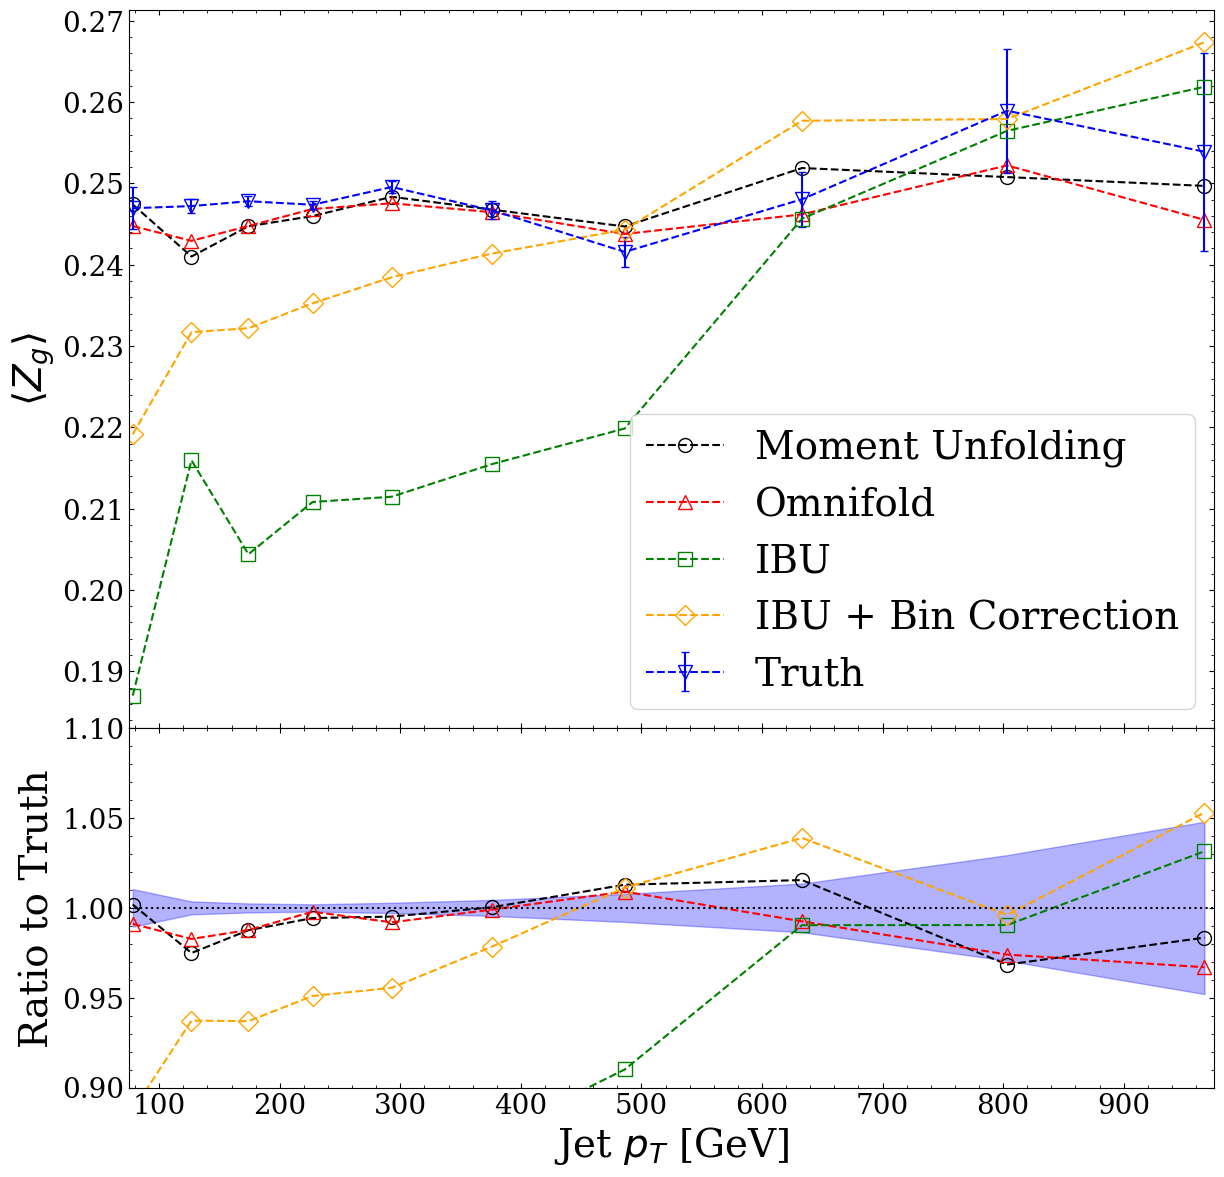

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [4, 2]})

# Plot settings for ax0
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].set_xticklabels([])
ax[0].tick_params(direction="in", which="both")
ax[0].minorticks_on()
ax[0].set_xlim(75, 975)
#ax[0].set_ylim(0.05, .25)


# Plot settings for ax1
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[1].tick_params(direction="in", which="both")
ax[1].minorticks_on()
width = 0.1
ax[1].set_ylim(1 - width, 1 + width)
ax[1].set_xlim(75, 975)
for sets, label, marker, color in datasets:
    plot_data(ax, sets, label, marker, color)

ylabel = r'$\langle Z_g{} \rangle$'.format(''#obs.upper()
                                       ) if moment == 1 else r'$\langle Z_g{}^{} \rangle$'.format(""#obs.upper()
                                                                       , moment
                                                                      )
if obs == 'm':
    unit = ' [GeV]' if moment == 1 else ' [GeV$^{}$]'.format(moment)
    ylabel += unit
ax[0].set_ylabel(ylabel, fontsize=28)

ax[0].legend(frameon=True, fontsize=28)

ax[1].set_xlabel("Jet $p_{T}$ [GeV]", fontsize=28)
ax[1].set_ylabel('Ratio to Truth', fontsize=28)
ax[1].axhline(1., ls=":", color="black")
# Remove the topmost y-tick label from ax[1]
# yticks = ax[1].get_yticks()
# ytick_labels = [f'{ytick:.3f}' for ytick in yticks]
# ytick_labels[-1] = ''  # Remove the topmost label
# ax[1].set_yticklabels(ytick_labels)
plt.subplots_adjust(wspace=0, hspace=0.0)

fig.savefig('figures/moment{}_{}_v_pT.pdf'.format(moment, obs), bbox_inches='tight')
plt.show()

In [ ]:
with open(f'npfiles/comparison_{obs}_{moment}.pkl', 'wb') as f:
    pickle.dump(datasets, f)

In [45]:
with open(f'npfiles/comparison_{obs}_{moment}.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [60]:
means_moment_unfolding, means_unbinnedx_omnifold_alt, truth, means_binnedx_alt, means_binnedx_alt_corrected = (datasets[i][0] for i in range(5))